# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

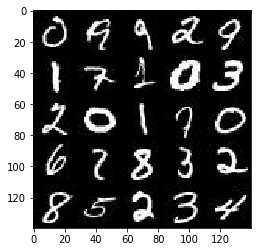

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

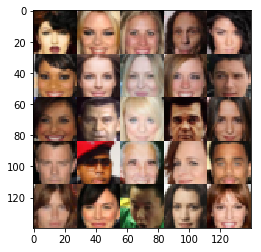

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    inputs_z = tf.placeholder(tf.float32, [None, z_dim])
    learningrate = tf.placeholder(tf.float32)
    
    return (inputs_real, inputs_z, learningrate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.20
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x512 now
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 7x7x256 now
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, learningrate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    print_every = 50
    show_every = 500
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learningrate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learningrate:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 2.2640
Epoch 1/2... Discriminator Loss: 0.6418... Generator Loss: 1.9082
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.7611
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 1.8440
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 1.2061
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.2829


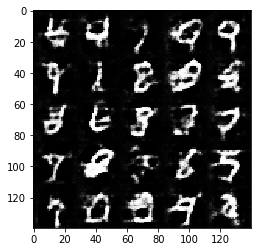

Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 1.7171... Generator Loss: 0.3323
Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 1.0827
Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.3844
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.1439
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.7933


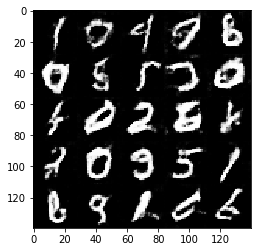

Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.8245... Generator Loss: 0.3028
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.2045
Epoch 2/2... Discriminator Loss: 1.0743... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.7177
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.5719


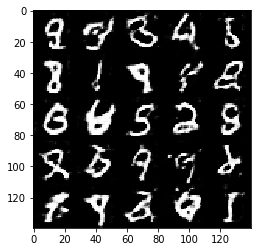

Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.2831
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.1762


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0164... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 2.7166
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.9346... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.0630


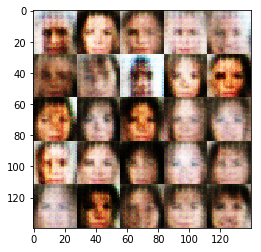

Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8589


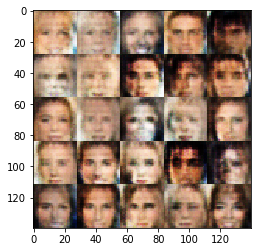

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7360


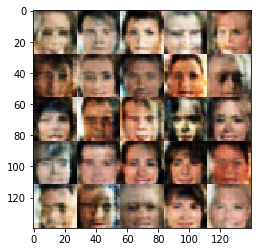

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8562


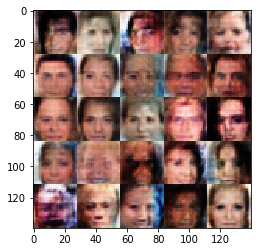

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.2054


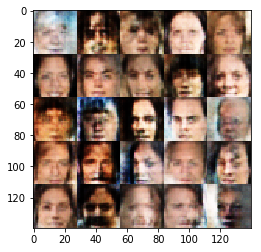

Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.0371


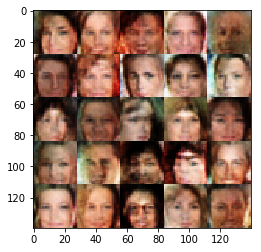

Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 1.0503


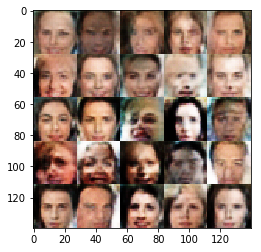

Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.7565


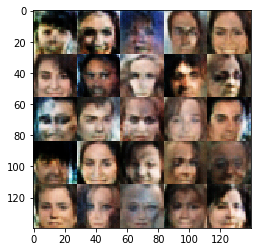

Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8321


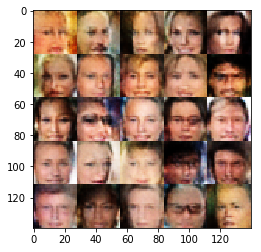

Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6468


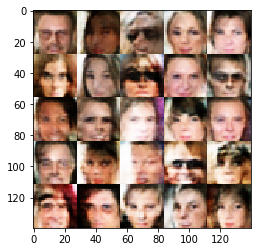

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8645


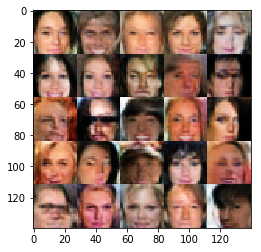

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.9357


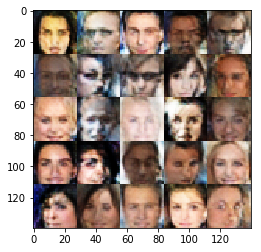

Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8400


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.